# Python Project

In [271]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from scipy import stats

from import_clean_data import import_clean_airport_df

### Questions:

- Where do airlines must put their focus on to avoid delays?
- How are delays distributed across airlines, regions and causes?


In [272]:
pd.set_option('display.max_columns', None)

df = import_clean_airport_df('airport_data.csv')

importing data...
Binarize delay types...
Creating delay size variables...
Getting dummy variables for delay sizes...


In [273]:
df
#DEP_DELAY_NEW, distance, 

,MONTH,DAY_OF_WEEK,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,SIZE_CARRIER_DELAY_BIG_CARRIER_DELAY,SIZE_CARRIER_DELAY_MEDIUM_CARRIER_DELAY,SIZE_CARRIER_DELAY_NO_DELAY,SIZE_CARRIER_DELAY_SMALL_CARRIER_DELAY,SIZE_WEATHER_DELAY_BIG_WEATHER_DELAY,SIZE_WEATHER_DELAY_MEDIUM_WEATHER_DELAY,SIZE_WEATHER_DELAY_NO_DELAY,SIZE_WEATHER_DELAY_SMALL_WEATHER_DELAY,SIZE_LATE_AIRCRAFT_DELAY_BIG_LATE_AIRCRAFT_DELAY,SIZE_LATE_AIRCRAFT_DELAY_MEDIUM_LATE_AIRCRAFT_DELAY,SIZE_LATE_AIRCRAFT_DELAY_NO_DELAY,SIZE_LATE_AIRCRAFT_DELAY_SMALL_LATE_AIRCRAFT_DELAY,SIZE_NAS_DELAY_BIG_NAS_DELAY,SIZE_NAS_DELAY_MEDIUM_NAS_DELAY,SIZE_NAS_DELAY_NO_DELAY,SIZE_NAS_DELAY_SMALL_NAS_DELAY,SIZE_DELAY_BIG_DELAY,SIZE_DELAY_MEDIUM_DELAY,SIZE_DELAY_NO_DELAY,SIZE_DELAY_SMALL_DELAY,SIZE_CARRIER_DELAY,SIZE_WEATHER_DELAY,SIZE_LATE_AIRCRAFT_DELAY,SIZE_NAS_DELAY,SIZE_DELAY
0,1,7,0.0,0,0800-0859,258.0,2,0.0,0.0,0.0,0.0,0.0,1,25,143,Southwest Airlines Co.,13056,107363,5873,1903352,13382999,0.000062,0.000099,8,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY
1,1,7,0.0,0,0700-0759,1747.0,7,0.0,0.0,0.0,0.0,0.0,1,29,191,Delta Air Lines Inc.,13056,73508,1174,1903352,12460183,0.000144,0.000149,3,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY
2,1,7,0.0,0,0600-0659,1747.0,7,0.0,0.0,0.0,0.0,0.0,1,27,199,Delta Air Lines Inc.,13056,73508,1174,1903352,12460183,0.000144,0.000149,18,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY
3,1,7,0.0,0,0600-0659,2248.0,9,0.0,0.0,0.0,0.0,0.0,1,27,180,Delta Air Lines Inc.,13056,73508,1174,1903352,12460183,0.000144,0.000149,2,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY
4,1,7,0.0,0,0001-0559,1514.0,7,0.0,0.0,0.0,0.0,0.0,1,10,182,Spirit Air Lines,13056,15023,1257,1903352,2688839,0.000009,0.000125,1,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6489057,12,7,0.0,0,2300-2359,102.0,1,0.0,0.0,0.0,0.0,0.0,11,3,123,Hawaiian Airlines Inc.,1318,7268,757,133573,905990,0.000120,0.000198,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY
6489058,12,7,0.0,0,1800-1859,102.0,1,0.0,0.0,0.0,0.0,0.0,11,2,123,Hawaiian Airlines Inc.,1318,7268,757,133573,905990,0.000120,0.000198,16,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY
6489059,12,7,0.0,0,2000-2059,102.0,1,0.0,0.0,0.0,0.0,0.0,11,2,123,Hawaiian Airlines Inc.,1318,7268,757,133573,905990,0.000120,0.000198,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY
6489060,12,7,0.0,0,2100-2159,102.0,1,0.0,0.0,0.0,0.0,0.0,12,3,123,Hawaiian Airlines Inc.,1318,7268,757,133573,905990,0.000120,0.000198,18,Lihue Airport,21.979,-159.346,Honolulu International

In [3]:
# Add States and Region
geolocator = Nominatim(user_agent="http")

airports = df[['DEPARTING_AIRPORT', 'LATITUDE', 'LONGITUDE']].drop_duplicates().reset_index(drop=True)
airports_col = airports.apply(lambda col: geolocator.reverse((col.LATITUDE, col.LONGITUDE)).raw['address']['ISO3166-2-lvl4'][-2:], axis=1)

airports = airports.reset_index(drop=True)
airports['state'] = airports_col
df = df.merge(airports[['DEPARTING_AIRPORT', 'state']], on='DEPARTING_AIRPORT')


df = df.merge(pd.read_csv('us census bureau regions and divisions.csv')[['State Code', 'Region']], 
    left_on='state', right_on='State Code', how='left') \
    .drop(columns='State Code')

In [4]:
# Add other delays

df['number_delays'] = df[['LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY']].sum(axis=1).fillna(0)
df.loc[(df['SIZE_DELAY']!='NO_DELAY') & (df['number_delays']==0), 'OTHER_CAUSES'] = 1
df.OTHER_CAUSES = df.OTHER_CAUSES.fillna(0)

df.loc[(df['OTHER_CAUSES'] == 1) & (df['DEP_DELAY_NEW'] >= 15), 'SIZE_OTHER_CAUSES'] = f'SMALL_OTHER_CAUSES'
df.loc[(df['OTHER_CAUSES'] == 1) & (df['DEP_DELAY_NEW'] > 30), 'SIZE_OTHER_CAUSES'] = f'MEDIUM_OTHER_CAUSES'
df.loc[(df['OTHER_CAUSES'] == 1) & (df['DEP_DELAY_NEW'] > 60), 'SIZE_OTHER_CAUSES'] = f'BIG_OTHER_CAUSES'
df.loc[(df[f'SIZE_OTHER_CAUSES'].isna()) & (df['DEP_DEL15']==0), 'SIZE_OTHER_CAUSES'] = 'NO_DELAY'

df['number_delays'] = df[['LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'OTHER_CAUSES']].sum(axis=1).fillna(0)
# Add previous airport region
df = df.merge(
            df[['DEPARTING_AIRPORT', 'Region']].rename(columns={'DEPARTING_AIRPORT':'PREVIOUS_AIRPORT', 'Region':'region_prev_airport'})\
            .drop_duplicates(subset='PREVIOUS_AIRPORT'),\
            on='PREVIOUS_AIRPORT', how='left'
)

df.head()

,MONTH,DAY_OF_WEEK,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,SIZE_CARRIER_DELAY_BIG_CARRIER_DELAY,SIZE_CARRIER_DELAY_MEDIUM_CARRIER_DELAY,SIZE_CARRIER_DELAY_NO_DELAY,SIZE_CARRIER_DELAY_SMALL_CARRIER_DELAY,SIZE_WEATHER_DELAY_BIG_WEATHER_DELAY,SIZE_WEATHER_DELAY_MEDIUM_WEATHER_DELAY,SIZE_WEATHER_DELAY_NO_DELAY,SIZE_WEATHER_DELAY_SMALL_WEATHER_DELAY,SIZE_LATE_AIRCRAFT_DELAY_BIG_LATE_AIRCRAFT_DELAY,SIZE_LATE_AIRCRAFT_DELAY_MEDIUM_LATE_AIRCRAFT_DELAY,SIZE_LATE_AIRCRAFT_DELAY_NO_DELAY,SIZE_LATE_AIRCRAFT_DELAY_SMALL_LATE_AIRCRAFT_DELAY,SIZE_NAS_DELAY_BIG_NAS_DELAY,SIZE_NAS_DELAY_MEDIUM_NAS_DELAY,SIZE_NAS_DELAY_NO_DELAY,SIZE_NAS_DELAY_SMALL_NAS_DELAY,SIZE_DELAY_BIG_DELAY,SIZE_DELAY_MEDIUM_DELAY,SIZE_DELAY_NO_DELAY,SIZE_DELAY_SMALL_DELAY,SIZE_CARRIER_DELAY,SIZE_WEATHER_DELAY,SIZE_LATE_AIRCRAFT_DELAY,SIZE_NAS_DELAY,SIZE_DELAY,state,Region,number_delays,OTHER_CAUSES,SIZE_OTHER_CAUSES,region_prev_airport
0,1,7,0.0,0,0800-0859,258.0,2,0.0,0.0,0.0,0.0,0.0,1,25,143,Southwest Airlines Co.,13056,107363,5873,1903352,13382999,0.000062,0.000099,8,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NV,West,0.0,0.0,NO_DELAY,NaN
1,1,7,0.0,0,0700-0759,1747.0,7,0.0,0.0,0.0,0.0,0.0,1,29,191,Delta Air Lines Inc.,13056,73508,1174,1903352,12460183,0.000144,0.000149,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NV,West,0.0,0.0,NO_DELAY,NaN
2,1,7,0.0,0,0600-0659,1747.0,7,0.0,0.0,0.0,0.0,0.0,1,27,199,Delta Air Lines Inc.,13056,73508,1174,1903352,12460183,0.000144,0.000149,18,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NV,West,0.0,0.0,NO_DELAY,NaN
3,1,7,0.0,0,0600-0659,2248.0,9,0.0,0.0,0.0,0.0,0.0,1,27,180,Delta Air Lines Inc.,13056,73508,1174,1903352,12460183,0.000144,0.000149,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NV,West,0.0,0.0,NO_DELAY,NaN
4,1,7,0.0,0,0001-0559,1514.0,7,0.0,0.0,0.0,0.0,0.0,1,10,182,Spirit Air Lines,13056,15023,1257,1903352,2688839,0.000009,0.000125,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NO_DELAY,NV,West,0.0,0.0,NO_DELAY,NaN


In [5]:
df[df['DEP_DEL15']==1].describe()

,MONTH,DAY_OF_WEEK,DEP_DELAY_NEW,DEP_DEL15,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,SIZE_CARRIER_DELAY_BIG_CARRIER_DELAY,SIZE_CARRIER_DELAY_MEDIUM_CARRIER_DELAY,SIZE_CARRIER_DELAY_NO_DELAY,SIZE_CARRIER_DELAY_SMALL_CARRIER_DELAY,SIZE_WEATHER_DELAY_BIG_WEATHER_DELAY,SIZE_WEATHER_DELAY_MEDIUM_WEATHER_DELAY,SIZE_WEATHER_DELAY_NO_DELAY,SIZE_WEATHER_DELAY_SMALL_WEATHER_DELAY,SIZE_LATE_AIRCRAFT_DELAY_BIG_LATE_AIRCRAFT_DELAY,SIZE_LATE_AIRCRAFT_DELAY_MEDIUM_LATE_AIRCRAFT_DELAY,SIZE_LATE_AIRCRAFT_DELAY_NO_DELAY,SIZE_LATE_AIRCRAFT_DELAY_SMALL_LATE_AIRCRAFT_DELAY,SIZE_NAS_DELAY_BIG_NAS_DELAY,SIZE_NAS_DELAY_MEDIUM_NAS_DELAY,SIZE_NAS_DELAY_NO_DELAY,SIZE_NAS_DELAY_SMALL_NAS_DELAY,SIZE_DELAY_BIG_DELAY,SIZE_DELAY_MEDIUM_DELAY,SIZE_DELAY_NO_DELAY,SIZE_DELAY_SMALL_DELAY,number_delays,OTHER_CAUSES
count,1.227368e+06,1.227368e+06,1.227368e+06,1227368.0,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1.227368e+06,1227368.0,1.227368e+06,1.227368e+06,1.227368e+06,1227368.0,1.227368e+06,1.227368e+06,1.227368e+06,1227368.0,1.227368e+06,1.227368e+06,1.227368e+06,1227368.0,1.227368e+06,1.227368e+06,1.227368e+06,1227368.0,1.227368e+06,1.227368e+06,1.227368e+06
mean,6.473086e+00,3.934775e+00,6.841584e+01,1.0,8.579677e+02,3.901447e+00,4.521586e-01,5.242275e-02,3.277509e-01,2.700901e-03,4.916618e-01,3.474653e+00,2.823882e+01,1.348790e+02,1.317401e+04,6.321175e+04,3.579936e+03,1.645376e+06,7.828103e+06,9.715877e-05,1.339499e-04,1.162142e+01,3.671139e+01,-9.325033e+01,1.607532e-01,6.451472e-02,1.309154e-01,7.112888e+01,8.721881e+00,1.854603e-01,1.582476e-01,0.0,1.084508e-01,2.879414e-02,1.459790e-02,0.0,9.030706e-03,2.223465e-01,1.709601e-01,0.0,9.835518e-02,1.346890e-01,9.706135e-02,0.0,9.600055e-02,3.463737e-01,2.923948e-01,0.0,3.612315e-01,1.531482e+00,2.047870e-01
std,3.329377e+00,1.992616e+00,8.684447e+01,0.0,6.034997e+02,2.379533e+00,4.977061e-01,2.228781e-01,4.693937e-01,5.189999e-02,4.999307e-01,1.771501e+00,2.129837e+01,4.648374e+01,8.731558e+03,3.510032e+04,4.094565e+03,1.095574e+06,5.043405e+06,8.588854e-05,4.811397e-05,6.765633e+00,5.250422e+00,1.681165e+01,4.325139e-01,4.883145e-01,8.562936e-01,1.924260e+01,3.778255e+00,3.886707e-01,3.649731e-01,0.0,3.109490e-01,1.672276e-01,1.199367e-01,0.0,9.460000e-02,4.158229e-01,3.764743e-01,0.0,2.977944e-01,3.413913e-01,2.960414e-01,0.0,2.945921e-01,4.758142e-01,4.548629e-01,0.0,4.803577e-01,6.571809e-01,4.035460e-01
min,1.000000e+00,1.000000e+00,1.500000e+01,1.0,6.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,4.400000e+01,1.100000e+03,5.582000e+03,1.000000e+00,7.047600e+04,4.737940e+05,0.000000e+00,7.134695e-06,0.000000e+00,1.844000e+01,-1.593460e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.000000e+00,0.000000e+00
25%,4.000000e+00,2.000000e+00,2.400000e+01,1.0,4.060000e+02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.100000e+01,9.900000e+01,5.847000e+03,2.488600e+04,7.250000e+02,7.325950e+05,2.688839e+06,3.419267e-05,9.889412e-05,5.000000e+00,3.343600e+01,-1.048800e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.900000e+01,6.040000e+00,0.000000e+00,0.

## Delays by Type

In [6]:
df_prov = df.DEP_DEL15.value_counts(normalize=True).reset_index().rename(columns={'index':'Delay', 'DEP_DEL15':'pct'})

df_prov.loc[df_prov['Delay']==0, 'Delay'] = 'Not delayed'
df_prov.loc[df_prov['Delay']==1, 'Delay'] = 'Delayed'
df_prov.pct = round(df_prov.pct, 2)

# plot

fig = px.pie(df_prov,
             values='pct',
             names='Delay',
             color_discrete_sequence=px.colors.qualitative.Plotly, height=600)
fig.update_layout(title_text='Percentage of Delayed Flights in 2019', title_x=0.5)
fig.show()

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig1.png", scale=2)

In [48]:
# How are those delays distributed through causes?
# There can be more than one flag for a delay

delay_causes_dict = {'Delay_Cause': ['Carrier Delay', 'Weather Delay', 'NAS Delay', 'Late Aircraft Delay', 'Security Delay', 'Other Causes'], \
                    'pct_of_delays': [round(df[df['DEP_DEL15']>0].CARRIER_DELAY.value_counts(normalize=True)[1], 3), \
                    round(df[df['DEP_DEL15']>0].WEATHER_DELAY.value_counts(normalize=True)[1], 3), \
                    round(df[df['DEP_DEL15']>0].NAS_DELAY.value_counts(normalize=True)[1], 3), \
                    round(df[df['DEP_DEL15']>0].LATE_AIRCRAFT_DELAY.value_counts(normalize=True)[1], 3), \
                    round(df[df['DEP_DEL15']>0].SECURITY_DELAY.value_counts(normalize=True)[1], 3), \
                    round(df[df['DEP_DEL15']>0].OTHER_CAUSES.value_counts(normalize=True)[1], 3)]}

delay_causes_df = pd.DataFrame(delay_causes_dict, index=list(range(0,6)))

delay_causes_df.pct_of_delays = delay_causes_df.pct_of_delays*100

# plot 

fig = px.bar(delay_causes_df, x='Delay_Cause', y='pct_of_delays', width=1100)

fig.update_layout(xaxis={'categoryorder':'total descending', 'title': 'Delay Cause'}, yaxis={'title': 'Percentage'},\
    title_text='Distribution of Delays by Cause')#, title_x=0.5)

fig.update_traces(marker_color='#EF553B')

fig.add_annotation(dict(font=dict(color='black',size=12),
                                        x=0,
                                        y=-0.22,
                                        showarrow=False,
                                        text="* There can be more than one flag for a delay (Other Causes only have one flag)",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
fig.show()

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig2.png", scale=2)

In [8]:
nas_size = df[(~df['SIZE_NAS_DELAY'].isna()) & (df['SIZE_NAS_DELAY']!='NO_DELAY')] \
    .SIZE_NAS_DELAY.value_counts(normalize=True)

carrier_size = df[(~df['SIZE_CARRIER_DELAY'].isna()) & (df['SIZE_CARRIER_DELAY']!='NO_DELAY')] \
    .SIZE_CARRIER_DELAY.value_counts(normalize=True)

weather_size = df[(~df['SIZE_WEATHER_DELAY'].isna()) & (df['SIZE_WEATHER_DELAY']!='NO_DELAY')] \
    .SIZE_WEATHER_DELAY.value_counts(normalize=True)

lateaircraft_size = df[(~df['SIZE_LATE_AIRCRAFT_DELAY'].isna()) & (df['SIZE_LATE_AIRCRAFT_DELAY']!='NO_DELAY')] \
    .SIZE_LATE_AIRCRAFT_DELAY.value_counts(normalize=True)

other_size = df[(~df['SIZE_OTHER_CAUSES'].isna()) & (df['SIZE_OTHER_CAUSES']!='NO_DELAY')] \
    .SIZE_OTHER_CAUSES.value_counts(normalize=True)

In [53]:
df_prov = df[df['DEP_DEL15']==1].SIZE_DELAY.value_counts(normalize=True).reset_index().rename(columns={'index':'Size Delay', 'SIZE_DELAY':'Percentage'})

df_prov.loc[df_prov['Size Delay']=='SMALL_DELAY', 'Size Delay'] = 'Small Delay'
df_prov.loc[df_prov['Size Delay']=='MEDIUM_DELAY', 'Size Delay'] = 'Medium Delay'
df_prov.loc[df_prov['Size Delay']=='BIG_DELAY', 'Size Delay'] = 'Big Delay'

# plot

fig = px.bar(df_prov,
             x='Percentage',
             y='Size Delay',
             color_discrete_sequence=px.colors.qualitative.Plotly, width=1000, 
             category_orders={'Size Delay':['Small Delay', 'Medium Delay', 'Big Delay']})
fig.update_layout(title_text='Percentage of Delayed Flights in 2019', title_x=0.5)
fig.show()

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})

fig.write_image("images/bardelay.png", scale=2)

In [15]:
delay_size_dist = { 'Delay Cause': ['Carrier Delay', 'Weather Delay', 'NAS Delay', 'Late Aircraft Delay', 'Other causes'], \
                    'pct_big_delay': [carrier_size.BIG_CARRIER_DELAY, weather_size.BIG_WEATHER_DELAY, \
                                        nas_size.BIG_NAS_DELAY, lateaircraft_size.BIG_LATE_AIRCRAFT_DELAY, other_size.BIG_OTHER_CAUSES], \
                    'pct_med_delay': [carrier_size.MEDIUM_CARRIER_DELAY, weather_size.MEDIUM_WEATHER_DELAY, \
                                        nas_size.MEDIUM_NAS_DELAY, lateaircraft_size.MEDIUM_LATE_AIRCRAFT_DELAY, other_size.MEDIUM_OTHER_CAUSES], \
                    'pct_small_delay': [carrier_size.SMALL_CARRIER_DELAY, weather_size.SMALL_WEATHER_DELAY, \
                                        nas_size.SMALL_NAS_DELAY, lateaircraft_size.SMALL_LATE_AIRCRAFT_DELAY, other_size.SMALL_OTHER_CAUSES] }
                    
delay_size_dist_df = pd.DataFrame(delay_size_dist)
delay_size_dist_df.pct_big_delay = round(delay_size_dist_df.pct_big_delay, 3)*100
delay_size_dist_df.pct_med_delay = round(delay_size_dist_df.pct_med_delay, 3)*100
delay_size_dist_df.pct_small_delay = round(delay_size_dist_df.pct_small_delay, 3)*100


delay_size_dist_df = pd.melt(delay_size_dist_df, 
                    id_vars='Delay Cause', 
                    value_vars=list(delay_size_dist_df.columns[1:]), # list of days of the week
                    var_name='Size Delay', 
                    value_name='Percentage')

# plot

fig = px.bar(delay_size_dist_df, x="Delay Cause", 
            color=delay_size_dist_df["Size Delay"].map({"pct_big_delay":"Big Delay","pct_med_delay":"Medium Delay","pct_small_delay":"Small Delay"}),
            y='Percentage',
            title="Size of Delay Distribution for Each Delay Cause",
            barmode='group',
            height=700, width= 1100,
            category_orders={'Delay Cause': delay_size_dist_df[delay_size_dist_df['Size Delay']=='pct_big_delay'] \
                .sort_values(by='Percentage', ascending=False)["Delay Cause"]}
            )

fig.show()

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig3.png", scale=2)

In [28]:
df.DEP_TIME_BLK.value_counts().sort_values
df.loc[(df['DEP_TIME_BLK']=='0600-0659') | (df['DEP_TIME_BLK']=='0700-0759'), 'DEP_TIME_BLK'] = '0600-0759'
df.loc[(df['DEP_TIME_BLK']=='0800-0859') | (df['DEP_TIME_BLK']=='0900-0959'), 'DEP_TIME_BLK'] = '0800-0959'
df.loc[(df['DEP_TIME_BLK']=='1000-1059') | (df['DEP_TIME_BLK']=='1100-1159'), 'DEP_TIME_BLK'] = '1000-1159'
df.loc[(df['DEP_TIME_BLK']=='1200-1259') | (df['DEP_TIME_BLK']=='1300-1359'), 'DEP_TIME_BLK'] = '1200-1359'
df.loc[(df['DEP_TIME_BLK']=='1400-1459') | (df['DEP_TIME_BLK']=='1500-1559'), 'DEP_TIME_BLK'] = '1400-1559'
df.loc[(df['DEP_TIME_BLK']=='1600-1659') | (df['DEP_TIME_BLK']=='1700-1759'), 'DEP_TIME_BLK'] = '1600-1759'
df.loc[(df['DEP_TIME_BLK']=='1800-1859') | (df['DEP_TIME_BLK']=='1900-1959'), 'DEP_TIME_BLK'] = '1800-1959'
df.loc[(df['DEP_TIME_BLK']=='2000-2059') | (df['DEP_TIME_BLK']=='2100-2159'), 'DEP_TIME_BLK'] = '2000-2159'
df.loc[(df['DEP_TIME_BLK']=='2200-2259') | (df['DEP_TIME_BLK']=='2300-2359'), 'DEP_TIME_BLK'] = '2200-2359'
df.DEP_TIME_BLK.value_counts().sort_values

<bound method Series.sort_values of 0600-0759    866436
0800-0959    848503
1000-1159    792635
1600-1759    777342
1400-1559    764221
1200-1359    751009
1800-1959    733031
2000-2159    563210
2200-2359    244095
0001-0559    148580
Name: DEP_TIME_BLK, dtype: int64>

(0.0, 4.0)

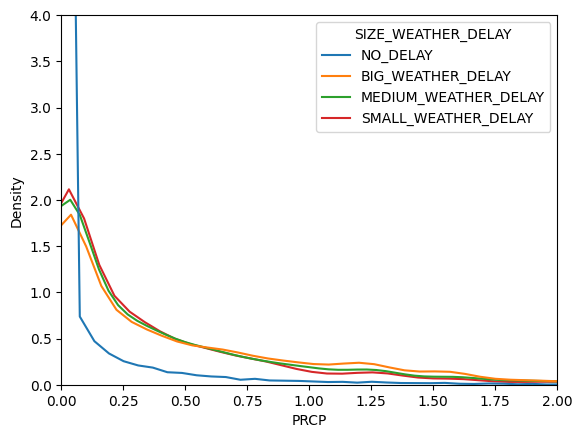

In [29]:
sns.kdeplot(
    df, x="PRCP", hue="SIZE_WEATHER_DELAY", common_norm=False,
)
plt.xlim(0,2)
plt.ylim(0,4)

<AxesSubplot: xlabel='AWND', ylabel='Density'>

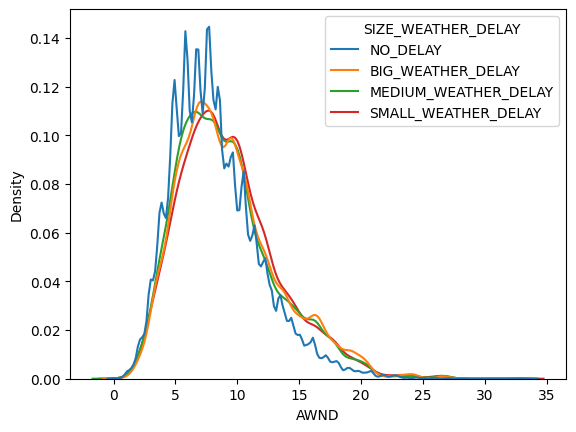

In [30]:
sns.kdeplot(
    df, x="AWND", hue="SIZE_WEATHER_DELAY", common_norm=False,
)

## Airlines analysis

In [54]:
# The percentages depend of the amount of flights of each airline

rank_df = df.groupby(['SIZE_DELAY']).CARRIER_NAME.value_counts(normalize=True).rename('Percentages').reset_index()

rank_df['rank'] = rank_df.sort_values(['Percentages'], ascending=[False]) \
             .groupby(['SIZE_DELAY']) \
             .cumcount() + 1

rank_df.head()

,SIZE_DELAY,CARRIER_NAME,Percentages,rank
0,BIG_DELAY,Southwest Airlines Co.,0.150131,1
1,BIG_DELAY,American Airlines Inc.,0.146930,2
2,BIG_DELAY,United Air Lines Inc.,0.115083,3
3,BIG_DELAY,SkyWest Airlines Inc.,0.104921,4
4,BIG_DELAY,Delta Air Lines Inc.,0.099582,5


In [221]:
df.groupby(['CARRIER_NAME']).DEP_DEL15.mean().reset_index().sort_values(by='DEP_DEL15')['CARRIER_NAME'].unique()

array(['Hawaiian Airlines Inc.', 'Delta Air Lines Inc.',
       'Midwest Airline, Inc.', 'Alaska Airlines Inc.',
       'Endeavor Air Inc.', 'SkyWest Airlines Inc.',
       'American Eagle Airlines Inc.', 'Spirit Air Lines',
       'Allegiant Air', 'Mesa Airlines Inc.', 'Comair Inc.',
       'United Air Lines Inc.', 'American Airlines Inc.',
       'Southwest Airlines Co.', 'Atlantic Southeast Airlines',
       'JetBlue Airways', 'Frontier Airlines Inc.'], dtype=object)

In [232]:
df_dumbbell_airlines = df.query("SIZE_DELAY != 'NO_DELAY'") \
    .groupby(['CARRIER_NAME']) \
    .SIZE_DELAY.value_counts(normalize=True) \
    .rename('Percentages').reset_index() \
    .sort_values(by=['CARRIER_NAME', 'Percentages'], ascending=[True,False])

df_dumbbell_airlines.loc[df_dumbbell_airlines['SIZE_DELAY'] == 'SMALL_DELAY', 'size_number'] = 1
df_dumbbell_airlines.loc[df_dumbbell_airlines['SIZE_DELAY'] == 'MEDIUM_DELAY', 'size_number'] = 3
df_dumbbell_airlines.loc[df_dumbbell_airlines['SIZE_DELAY'] == 'BIG_DELAY', 'size_number'] = 10

#plot

fig = px.scatter(df_dumbbell_airlines, \
    x="Percentages", y="CARRIER_NAME", color="SIZE_DELAY", size='size_number', \
    category_orders={ 
        "SIZE_DELAY": ['SMALL_DELAY', 'MEDIUM_DELAY', 'BIG_DELAY'], \
        "CARRIER_NAME": df_dumbbell_airlines[df_dumbbell_airlines['SIZE_DELAY']=='BIG_DELAY'].sort_values(by='Percentages').CARRIER_NAME.unique()
        },
height=800, width=1000)

for i in df_dumbbell_airlines["CARRIER_NAME"].unique():

    df_sub = df_dumbbell_airlines[df_dumbbell_airlines["CARRIER_NAME"] == i]


fig.update_layout(title_text='Distribution of Delays by Size', plot_bgcolor='white',
                  xaxis_title='Percentage from delayed flights', yaxis_title='Carrier Name',
                  legend_title="Size of Delay")
fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

newnames = {'SMALL_DELAY':'Small Delay', 'MEDIUM_DELAY': 'Medium Delay', 'BIG_DELAY': 'Big Delay'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

fig.show()

fig.update_layout({
#'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})
fig.write_image("images/fig4.png", scale=2)

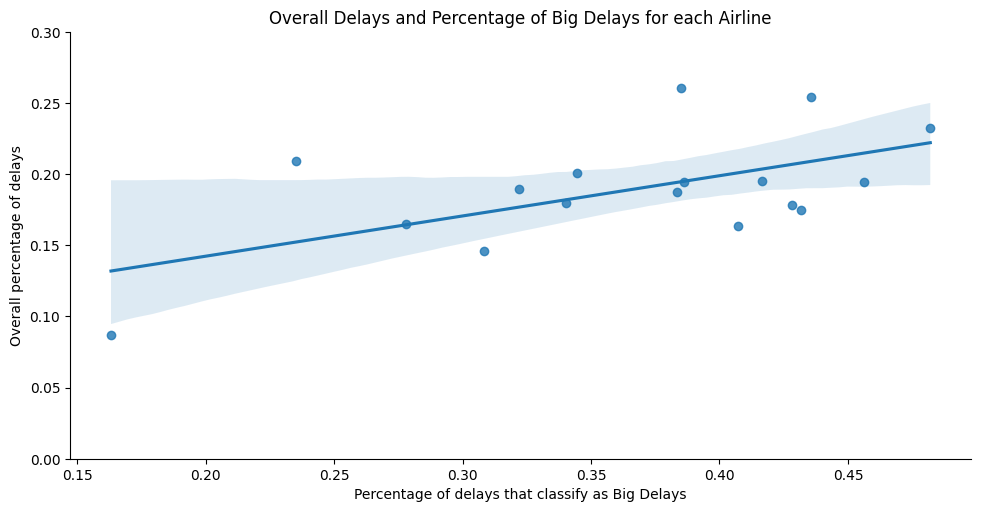

In [56]:

airline_delays = df_dumbbell_airlines \
    .merge( df[['CARRIER_NAME', 'DEP_DEL15']] \
        .groupby('CARRIER_NAME')['DEP_DEL15'] \
        .value_counts(normalize=True) \
        .rename('Overall percentage of delays') \
        .reset_index() \
        .query('DEP_DEL15 == 1'), \
    on='CARRIER_NAME' ) \
    .query("SIZE_DELAY == 'BIG_DELAY'") \
    .rename(columns={'Percentages':'Percentage of delays that classify as Big Delays'})

sns.lmplot(airline_delays, x='Percentage of delays that classify as Big Delays', y='Overall percentage of delays', aspect=2)
plt.ylim(0,0.3)
plt.title('Overall Delays and Percentage of Big Delays for each Airline')
plt.savefig('delays_airlines.png')

In [88]:
airline_delays[['Percentage of delays that classify as Big Delays', 'Overall percentage of delays']].corr(numeric_only=True)

,Percentage of delays that classify as Big Delays,Overall percentage of delays
Percentage of delays that classify as Big Delays,1.000000,0.590942
Overall percentage of delays,0.590942,1.000000


In [234]:
df_dumbbell_airlines = df \
    .groupby(['CARRIER_NAME']) \
    .SIZE_DELAY.value_counts(normalize=True) \
    .rename('Percentages').reset_index() \
    .sort_values(by=['CARRIER_NAME', 'Percentages'], ascending=[True,False])

df_dumbbell_airlines.loc[df_dumbbell_airlines['SIZE_DELAY'] == 'SMALL_DELAY', 'size_number'] = 1
df_dumbbell_airlines.loc[df_dumbbell_airlines['SIZE_DELAY'] == 'MEDIUM_DELAY', 'size_number'] = 3
df_dumbbell_airlines.loc[df_dumbbell_airlines['SIZE_DELAY'] == 'BIG_DELAY', 'size_number'] = 10

df_dumbbell_airlines = df_dumbbell_airlines.query("SIZE_DELAY != 'NO_DELAY'")
# plot 

fig = px.scatter(df_dumbbell_airlines, \
    x="Percentages", y="CARRIER_NAME", color="SIZE_DELAY", size='size_number', \
    category_orders={ 
        "SIZE_DELAY": ['SMALL_DELAY', 'MEDIUM_DELAY', 'BIG_DELAY'], \
        "CARRIER_NAME": df_dumbbell_airlines[df_dumbbell_airlines['SIZE_DELAY']=='BIG_DELAY'].sort_values(by='Percentages').CARRIER_NAME.unique()
        #"CARRIER_NAME": df.groupby(['CARRIER_NAME']).DEP_DEL15.mean().reset_index().sort_values(by='DEP_DEL15')['CARRIER_NAME'].unique()
        },
height=800, width=1000)

for i in df_dumbbell_airlines["CARRIER_NAME"].unique():

    df_sub = df_dumbbell_airlines[df_dumbbell_airlines["CARRIER_NAME"] == i]

fig.update_layout(title_text='Percentage of Delays by Size from all Flights', plot_bgcolor='white',
                  xaxis_title='Percentage from all flights', yaxis_title='Carrier Name',
                  legend_title="Size of Delay")
fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

newnames = {'SMALL_DELAY':'Small Delay', 'MEDIUM_DELAY': 'Medium Delay', 'BIG_DELAY': 'Big Delay'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

fig.show()

fig.update_layout({
#'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})
fig.write_image("images/fig5.png", scale=2)

## Cause of delay distribution for each size of delay

In [265]:
carrier_df = df.groupby(['SIZE_DELAY']) \
        .CARRIER_DELAY.value_counts(normalize=True).rename('CARRIER_DELAY_PERC') \
        .reset_index() \
        .query("CARRIER_DELAY == 1").drop(columns='CARRIER_DELAY')

carrier_df = pd.melt(carrier_df, 
    id_vars='SIZE_DELAY', 
    value_vars=list(carrier_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')


lateaircraft_df = df.groupby(['SIZE_DELAY']) \
        .LATE_AIRCRAFT_DELAY.value_counts(normalize=True).rename('LATEAIRCRAFT_DELAY_PERC') \
        .reset_index() \
        .query("LATE_AIRCRAFT_DELAY == 1").drop(columns='LATE_AIRCRAFT_DELAY')

lateaircraft_df = pd.melt(lateaircraft_df, 
    id_vars='SIZE_DELAY', 
    value_vars=list(lateaircraft_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')


nas_df = df.groupby(['SIZE_DELAY']) \
        .NAS_DELAY.value_counts(normalize=True).rename('NAS_DELAY_PERC') \
        .reset_index() \
        .query("NAS_DELAY == 1").drop(columns='NAS_DELAY')

nas_df = pd.melt(nas_df, 
    id_vars='SIZE_DELAY', 
    value_vars=list(nas_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')


weather_df = df.groupby(['SIZE_DELAY']) \
        .WEATHER_DELAY.value_counts(normalize=True).rename('WEATHER_DELAY_PERC') \
        .reset_index() \
        .query("WEATHER_DELAY == 1").drop(columns='WEATHER_DELAY')

weather_df = pd.melt(weather_df, 
    id_vars='SIZE_DELAY', 
    value_vars=list(weather_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')


other_df = df.groupby(['SIZE_DELAY']) \
        .OTHER_CAUSES.value_counts(normalize=True).rename('OTHER_DELAY_PERC') \
        .reset_index() \
        .query("OTHER_CAUSES == 1").drop(columns='OTHER_CAUSES')

other_df = pd.melt(other_df, 
    id_vars='SIZE_DELAY', 
    value_vars=list(other_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')

In [269]:
df_prov = pd.concat([lateaircraft_df, carrier_df, nas_df, weather_df, other_df])

df_prov.loc[df_prov.SIZE_DELAY=='BIG_DELAY', 'SIZE_DELAY'] = 'Big Delay'
df_prov.loc[df_prov.SIZE_DELAY=='MEDIUM_DELAY', 'SIZE_DELAY'] = 'Medium Delay'
df_prov.loc[df_prov.SIZE_DELAY=='SMALL_DELAY', 'SIZE_DELAY'] = 'Small Delay'

df_prov = df_prov.rename(columns={'SIZE_DELAY':'Size Delay'})

# plot

fig = px.bar(df_prov, x="Size Delay", 
            color=df_prov["Delay Cause"].map({"CARRIER_DELAY_PERC":"Carrier Delay","LATEAIRCRAFT_DELAY_PERC":"Late Aircraft Delay", \
                "NAS_DELAY_PERC":"NAS Delay", "WEATHER_DELAY_PERC":"Weather Delay", 'OTHER_DELAY_PERC':'Other'}),
            y='Percentage',
            title="Cause of Delay Distribution for Each Delay Size",
            barmode='group',
            height=450, width=1100,
            category_orders={'SIZE_DELAY': df_prov.sort_values(by='Size Delay', ascending=False)["Size Delay"]}
            )

fig.show()

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig6.png", scale=2)

In [59]:
df.groupby(['DAY_OF_WEEK','SIZE_DELAY']) \
        .CARRIER_DELAY.value_counts(normalize=True).rename('CARRIER_DELAY_PERC') \
        .reset_index() \
        .query("CARRIER_DELAY == 1").drop(columns='CARRIER_DELAY') \
        .query("SIZE_DELAY == 'BIG_DELAY'")

,DAY_OF_WEEK,SIZE_DELAY,CARRIER_DELAY_PERC
0,1,BIG_DELAY,0.528735
7,2,BIG_DELAY,0.521346
14,3,BIG_DELAY,0.502036
21,4,BIG_DELAY,0.521647
28,5,BIG_DELAY,0.543740
35,6,BIG_DELAY,0.579312
42,7,BIG_DELAY,0.561897


In [60]:
time_la_delay = df.groupby(['DEP_TIME_BLK','SIZE_DELAY']) \
        .LATE_AIRCRAFT_DELAY.value_counts(normalize=True).rename('LATEAIRCRAFT_DELAY_PERC') \
        .reset_index() \
        .query("LATE_AIRCRAFT_DELAY == 1").drop(columns='LATE_AIRCRAFT_DELAY') \
        .query("SIZE_DELAY == 'BIG_DELAY'")

time_carrier_delay = df.groupby(['DEP_TIME_BLK','SIZE_DELAY']) \
        .CARRIER_DELAY.value_counts(normalize=True).rename('CARRIER_DELAY_PERC') \
        .reset_index() \
        .query("CARRIER_DELAY == 1").drop(columns='CARRIER_DELAY') \
        .query("SIZE_DELAY == 'BIG_DELAY'")

time_nas_delay = df.groupby(['DEP_TIME_BLK','SIZE_DELAY']) \
        .NAS_DELAY.value_counts(normalize=True).rename('NAS_DELAY_PERC') \
        .reset_index() \
        .query("NAS_DELAY == 1").drop(columns='NAS_DELAY') \
        .query("SIZE_DELAY == 'BIG_DELAY'")
        
time_weather_delay = df.groupby(['DEP_TIME_BLK','SIZE_DELAY']) \
        .WEATHER_DELAY.value_counts(normalize=True).rename('WEATHER_DELAY_PERC') \
        .reset_index() \
        .query("WEATHER_DELAY == 1").drop(columns='WEATHER_DELAY') \
        .query("SIZE_DELAY == 'BIG_DELAY'")

time_concurrent_flights = df.groupby(['DEP_TIME_BLK']).CONCURRENT_FLIGHTS.mean().reset_index()

# plot 

fig = px.bar(
    time_carrier_delay.merge(time_la_delay, how='inner').merge(time_nas_delay, how='inner').merge(time_weather_delay), 
    x="DEP_TIME_BLK", y=["CARRIER_DELAY_PERC", "LATEAIRCRAFT_DELAY_PERC", 'NAS_DELAY_PERC', 'WEATHER_DELAY_PERC'], 
    title="Percentage of big delays by time slot and cause")
    
fig.update_layout(barmode='group')
fig.show()

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig8.png", scale=2)

In [71]:
# Hacer esto por Region
df_prov = df[df['DEP_DEL15']==1].groupby(['DEP_TIME_BLK']).LATE_AIRCRAFT_DELAY.mean().reset_index() \
    .merge(df[df['DEP_DEL15']==1].groupby(['DEP_TIME_BLK']).CARRIER_DELAY.mean().reset_index()) \
    .merge(df[df['DEP_DEL15']==1].groupby(['DEP_TIME_BLK']).NAS_DELAY.mean().reset_index()) \
    .merge(df[df['DEP_DEL15']==1].groupby(['DEP_TIME_BLK']).WEATHER_DELAY.mean().reset_index())

fig = px.bar(
    df_prov, x="DEP_TIME_BLK", y=["CARRIER_DELAY", "LATE_AIRCRAFT_DELAY", 'NAS_DELAY', 'WEATHER_DELAY'], 
    title="Percentage of Delays by Time Slot and Cause", width=1100
)

fig.update_layout(barmode='group', plot_bgcolor='white',
                  xaxis_title='Time slot', yaxis_title='Percentage from delayed flights',
                  legend_title="Cause of Delay")

newnames = {'CARRIER_DELAY': 'Carrier Delay', 'LATE_AIRCRAFT_DELAY': 'Late Aircraft Delay', 
            'NAS_DELAY': 'Nas Delay', 'WEATHER_DELAY': 'Weather Delay'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

fig.show()

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig8.png", scale=2)

In [74]:
fig = px.bar(
    df.groupby(['DEP_TIME_BLK']).DEP_DEL15.mean().reset_index(), 
    x="DEP_TIME_BLK", 
    y=["DEP_DEL15"], 
    title="Percentage of delayed flights by time slot", width=1100
)

fig.update_layout(barmode='group', plot_bgcolor='white',
                  xaxis_title='Time slot', yaxis_title='Percentage of delayed flights')
fig.show()

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig7.png", scale=2)

In [192]:
df_prov = df[df['DEP_DEL15']==1].groupby(['DEP_TIME_BLK']).number_delays.value_counts(normalize=True).rename('pct').reset_index()
df_prov.number_delays = df_prov.number_delays.astype('int')
df_prov = df_prov.pivot(index='DEP_TIME_BLK', columns='number_delays', values='pct').reset_index().fillna(0)


fig = px.bar(
    df_prov, x="DEP_TIME_BLK", y=[1,2,3,4], 
    title="Percentage of delays by time slot and cause"
)

fig.update_layout(barmode='group')

In [84]:
df.SIZE_DELAY.value_counts(normalize=True)

NO_DELAY        0.810856
SMALL_DELAY     0.068325
BIG_DELAY       0.065515
MEDIUM_DELAY    0.055305
Name: SIZE_DELAY, dtype: float64

In [24]:
print(df[df['LATE_AIRCRAFT_DELAY']==1].CARRIER_DELAY.value_counts(normalize=True))
print(df[df['LATE_AIRCRAFT_DELAY']==1].WEATHER_DELAY.value_counts(normalize=True))

0.0    0.512087
1.0    0.487913
Name: CARRIER_DELAY, dtype: float64
0.0    0.9452
1.0    0.0548
Name: WEATHER_DELAY, dtype: float64


In [25]:
print(df[df['CARRIER_DELAY']==1].LATE_AIRCRAFT_DELAY.value_counts(normalize=True))
print(df[df['CARRIER_DELAY']==1].WEATHER_DELAY.value_counts(normalize=True))

1.0    0.53054
0.0    0.46946
Name: LATE_AIRCRAFT_DELAY, dtype: float64
0.0    0.994637
1.0    0.005363
Name: WEATHER_DELAY, dtype: float64


In [26]:
print(df[df['WEATHER_DELAY']==1].LATE_AIRCRAFT_DELAY.value_counts(normalize=True))
print(df[df['WEATHER_DELAY']==1].CARRIER_DELAY.value_counts(normalize=True))

1.0    0.513957
0.0    0.486043
Name: LATE_AIRCRAFT_DELAY, dtype: float64
0.0    0.953747
1.0    0.046253
Name: CARRIER_DELAY, dtype: float64


In [85]:
de_prov

,number_delays,SIZE_DELAY,pct
0,1.0,SMALL_DELAY,0.447712
1,1.0,BIG_DELAY,0.281964
2,1.0,MEDIUM_DELAY,0.270324
3,2.0,BIG_DELAY,0.427620
4,2.0,MEDIUM_DELAY,0.328221
5,2.0,SMALL_DELAY,0.244159
6,3.0,BIG_DELAY,0.429004
7,3.0,MEDIUM_DELAY,0.290528
8,3.0,SMALL_DELAY,0.280468
9,4.0,BIG_DELAY,0.650869


In [249]:
df_prov = df[df['SIZE_DELAY']!='NO_DELAY'] \
    .groupby('number_delays').SIZE_DELAY.value_counts(normalize=True).rename('pct').reset_index() \
    .sort_values(by='SIZE_DELAY', ascending=False)

fig = px.line(df_prov, x="number_delays", y="pct", color='SIZE_DELAY', 
                title='Size of delay distribution for flights with different number of flags', 
                width=1100)
fig.update_xaxes(type='category')

fig.update_layout(plot_bgcolor='white',
                  xaxis_title='Number of Delay Causes', yaxis_title='Percentage',
                  legend_title="Size of Delay")

newnames = {'SMALL_DELAY': 'Small Delay', 'MEDIUM_DELAY': 'Medium Delay', 
            'BIG_DELAY': 'Big Delay'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.show()

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig10.png", scale=2)

In [259]:
print(px.colors.sequential.Plasma_r)

['#f0f921', '#fdca26', '#fb9f3a', '#ed7953', '#d8576b', '#bd3786', '#9c179e', '#7201a8', '#46039f', '#0d0887']


In [270]:
df_prov = df[df['SIZE_DELAY']!='NO_DELAY'] \
    .groupby('SIZE_DELAY').number_delays.value_counts(normalize=True).rename('pct').reset_index() \
    .sort_values(by='number_delays')

df_prov.number_delays = df_prov.number_delays.astype('str')

df_prov.loc[df_prov['SIZE_DELAY']=='BIG_DELAY', 'SIZE_DELAY'] = 'Big Delay'
df_prov.loc[df_prov['SIZE_DELAY']=='MEDIUM_DELAY', 'SIZE_DELAY'] = 'Medium Delay'
df_prov.loc[df_prov['SIZE_DELAY']=='SMALL_DELAY', 'SIZE_DELAY'] = 'Small Delay'

fig = px.bar(df_prov, x="SIZE_DELAY", y="pct", color='number_delays', 
                title='Number of flags distribution for flights with different delay sizes', 
                color_discrete_sequence= ['#fb9f3a', '#ed7953', '#d8576b', '#bd3786'],
                width=1100, height=400)
fig.update_xaxes(type='category')

fig.update_layout(plot_bgcolor='white',
                  xaxis_title='Size of Delay', yaxis_title='Percentage',
                  legend_title="Number of Flags")

# newnames = {'SMALL_DELAY': 'Small Delay', 'MEDIUM_DELAY': 'Medium Delay', 
#             'BIG_DELAY': 'Big Delay'}
# fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.show()

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig10.png", scale=2)

## Proporción promedio de las causas más comunes de delay según tamaño de delay para las aeorlineas

In [27]:
def perc_delays(size_delay):

    carrier_delay_perc = df.query(f"SIZE_DELAY == '{size_delay}'")  \
        .groupby(['CARRIER_NAME']) \
        .CARRIER_DELAY.value_counts(normalize=True).rename('CARRIER_DELAY_PERC') \
        .reset_index() \
        .query("CARRIER_DELAY == 1").drop(columns='CARRIER_DELAY')

    lateairc_delay_perc = df.query(f"SIZE_DELAY == '{size_delay}'")  \
        .groupby(['CARRIER_NAME']) \
        .LATE_AIRCRAFT_DELAY.value_counts(normalize=True).rename('LATEAIRCRAFT_DELAY_PERC') \
        .reset_index() \
        .query("LATE_AIRCRAFT_DELAY == 1").drop(columns='LATE_AIRCRAFT_DELAY')

    security_delay_perc = df.query(f"SIZE_DELAY == '{size_delay}'")  \
        .groupby(['CARRIER_NAME']) \
        .SECURITY_DELAY.value_counts(normalize=True).rename('SECURITY_DELAY_PERC') \
        .reset_index() \
        .query("SECURITY_DELAY == 1").drop(columns='SECURITY_DELAY')

    nas_delay_perc = df.query(f"SIZE_DELAY == '{size_delay}'")  \
        .groupby(['CARRIER_NAME']) \
        .NAS_DELAY.value_counts(normalize=True).rename('NAS_DELAY_PERC') \
        .reset_index() \
        .query("NAS_DELAY == 1").drop(columns='NAS_DELAY')

    weather_delay_perc = df.query(f"SIZE_DELAY == '{size_delay}'")  \
        .groupby(['CARRIER_NAME']) \
        .WEATHER_DELAY.value_counts(normalize=True).rename('WEATHER_DELAY_PERC') \
        .reset_index() \
        .query("WEATHER_DELAY == 1").drop(columns='WEATHER_DELAY')

    return carrier_delay_perc, lateairc_delay_perc, security_delay_perc, nas_delay_perc, weather_delay_perc

In [28]:
carrier_delay_perc, lateairc_delay_perc, security_delay_perc, nas_delay_perc, weather_delay_perc = perc_delays('BIG_DELAY')

df_dumbbell_airlines.query("SIZE_DELAY == 'BIG_DELAY'") \
    .merge( 
    carrier_delay_perc.merge(lateairc_delay_perc, how='outer') \
    .merge(security_delay_perc, how='outer') \
    .merge(nas_delay_perc, how='outer') \
    .merge(weather_delay_perc, how='outer') 
    , how='left').drop(columns=['SIZE_DELAY', 'size_number']).fillna(0).mean(axis=0, numeric_only=True)

Percentages                0.070856
CARRIER_DELAY_PERC         0.526764
LATEAIRCRAFT_DELAY_PERC    0.611924
SECURITY_DELAY_PERC        0.004456
NAS_DELAY_PERC             0.400151
WEATHER_DELAY_PERC         0.079372
dtype: float64

In [29]:
carrier_delay_perc, lateairc_delay_perc, security_delay_perc, nas_delay_perc, weather_delay_perc = perc_delays('MEDIUM_DELAY')

df_dumbbell_airlines.query("SIZE_DELAY == 'MEDIUM_DELAY'") \
    .merge( 
    carrier_delay_perc.merge(lateairc_delay_perc, how='outer') \
    .merge(security_delay_perc, how='outer') \
    .merge(nas_delay_perc, how='outer') \
    .merge(weather_delay_perc, how='outer') 
    , how='left').drop(columns=['SIZE_DELAY', 'size_number']).fillna(0).mean(axis=0, numeric_only=True)

Percentages                0.054722
CARRIER_DELAY_PERC         0.504215
LATEAIRCRAFT_DELAY_PERC    0.555483
SECURITY_DELAY_PERC        0.003965
NAS_DELAY_PERC             0.360616
WEATHER_DELAY_PERC         0.054419
dtype: float64

In [30]:
carrier_delay_perc, lateairc_delay_perc, security_delay_perc, nas_delay_perc, weather_delay_perc = perc_delays('SMALL_DELAY')

df_dumbbell_airlines.query("SIZE_DELAY == 'SMALL_DELAY'") \
    .merge( 
    carrier_delay_perc.merge(lateairc_delay_perc, how='outer') \
    .merge(security_delay_perc, how='outer') \
    .merge(nas_delay_perc, how='outer') \
    .merge(weather_delay_perc, how='outer') 
    , how='left').drop(columns=['SIZE_DELAY', 'size_number']).fillna(0).mean(axis=0, numeric_only=True)

Percentages                0.063461
CARRIER_DELAY_PERC         0.305341
LATEAIRCRAFT_DELAY_PERC    0.285792
SECURITY_DELAY_PERC        0.002889
NAS_DELAY_PERC             0.294704
WEATHER_DELAY_PERC         0.031830
dtype: float64

In [31]:
df.groupby('SIZE_DELAY').CONCURRENT_FLIGHTS.mean()

SIZE_DELAY
BIG_DELAY       28.006680
MEDIUM_DELAY    28.442470
NO_DELAY        27.742964
SMALL_DELAY     28.296569
Name: CONCURRENT_FLIGHTS, dtype: float64

In [32]:
df[df['LATE_AIRCRAFT_DELAY']==1].groupby('SIZE_DELAY').CONCURRENT_FLIGHTS.mean()

SIZE_DELAY
BIG_DELAY       27.753152
MEDIUM_DELAY    27.325996
SMALL_DELAY     27.533864
Name: CONCURRENT_FLIGHTS, dtype: float64

In [33]:
df[(df['LATE_AIRCRAFT_DELAY']==1) | (df['SIZE_DELAY']=='NO_DELAY')].groupby('SIZE_DELAY').DISTANCE.mean()

SIZE_DELAY
BIG_DELAY       812.121953
MEDIUM_DELAY    789.993399
NO_DELAY        832.654497
SMALL_DELAY     754.454009
Name: DISTANCE, dtype: float64

<AxesSubplot: xlabel='PRCP', ylabel='SIZE_DELAY'>

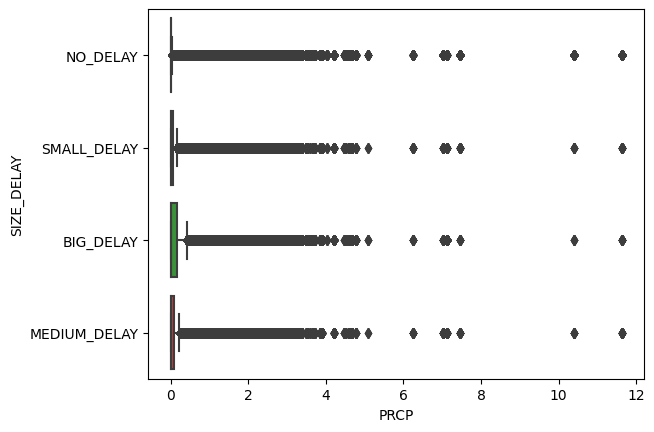

In [34]:
sns.boxplot(data=df, x="PRCP", y="SIZE_DELAY")

## States by zone

In [43]:
# Add States
geolocator = Nominatim(user_agent="http")

airports = df[['DEPARTING_AIRPORT', 'LATITUDE', 'LONGITUDE']].drop_duplicates().reset_index(drop=True)
airports_col = airports.apply(lambda col: geolocator.reverse((col.LATITUDE, col.LONGITUDE)).raw['address']['ISO3166-2-lvl4'][-2:], axis=1)

airports = airports.reset_index(drop=True)
airports['state'] = airports_col
df = df.merge(airports[['DEPARTING_AIRPORT', 'state']], on='DEPARTING_AIRPORT')

In [44]:
df = df.merge(pd.read_csv('us census bureau regions and divisions.csv')[['State Code', 'Region']], 
    left_on='state', right_on='State Code', how='left') \
    .drop(columns='State Code')

In [45]:
df.groupby(['Region','SIZE_WEATHER_DELAY']).PRCP.median()

Region     SIZE_WEATHER_DELAY  
Midwest    BIG_WEATHER_DELAY       0.18
           MEDIUM_WEATHER_DELAY    0.12
           NO_DELAY                0.00
           SMALL_WEATHER_DELAY     0.12
Northeast  BIG_WEATHER_DELAY       0.38
           MEDIUM_WEATHER_DELAY    0.32
           NO_DELAY                0.00
           SMALL_WEATHER_DELAY     0.29
South      BIG_WEATHER_DELAY       0.32
           MEDIUM_WEATHER_DELAY    0.25
           NO_DELAY                0.00
           SMALL_WEATHER_DELAY     0.21
West       BIG_WEATHER_DELAY       0.10
           MEDIUM_WEATHER_DELAY    0.07
           NO_DELAY                0.00
           SMALL_WEATHER_DELAY     0.03
Name: PRCP, dtype: float64

In [75]:
weather_delay_prcp = df \
    .groupby(['Region','MONTH','SIZE_WEATHER_DELAY']).PRCP.median().reset_index()

# plot 

fig = px.line(weather_delay_prcp, x="MONTH", y="PRCP", color='SIZE_WEATHER_DELAY', title='', facet_row = 'Region', height=800)
fig.show()

In [76]:
weather_delay_prcp = df \
    .groupby(['Region','MONTH','WEATHER_DELAY'])['PRCP'].quantile(0.5).reset_index()

# plot 

fig = px.line(weather_delay_prcp, x="MONTH", y="PRCP", color='WEATHER_DELAY', title='', facet_row = 'Region', height=800)
fig.show()

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig9.png", scale=2)

In [77]:
weather_delay_prcp = df[df['PRCP']>0] \
    .groupby(['Region','MONTH','WEATHER_DELAY'])['PRCP'].quantile(0.5).reset_index()

# plot 

fig = px.line(weather_delay_prcp, x="MONTH", y="PRCP", color='WEATHER_DELAY', title='', facet_row = 'Region', height=800)
fig.show()

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig10.png", scale=2)

In [58]:
weather_delay_prcp = df \
    .groupby(['Region','MONTH'])['WEATHER_DELAY'].mean().reset_index()

# plot 

fig = px.line(weather_delay_prcp, x="MONTH", y="WEATHER_DELAY", color='Region', title='', facet_row='Region', height=700, width=600)
fig.show()

In [66]:
df_prov = df.merge(
            df[['DEPARTING_AIRPORT', 'Region']].rename(columns={'DEPARTING_AIRPORT':'PREVIOUS_AIRPORT', 'Region':'region_prev_airport'})\
            .drop_duplicates(subset='PREVIOUS_AIRPORT'),\
            on='PREVIOUS_AIRPORT', how='inner'
)

weather_delay_prcp = df_prov \
    .groupby(['region_prev_airport','MONTH'])['SIZE_LATE_AIRCRAFT_DELAY_BIG_LATE_AIRCRAFT_DELAY'].mean().reset_index()

# plot 

fig = px.line(weather_delay_prcp, x="MONTH", y="SIZE_LATE_AIRCRAFT_DELAY_BIG_LATE_AIRCRAFT_DELAY", \
    color='region_prev_airport', title='', facet_row='region_prev_airport', height=700, width=600)
fig.show()

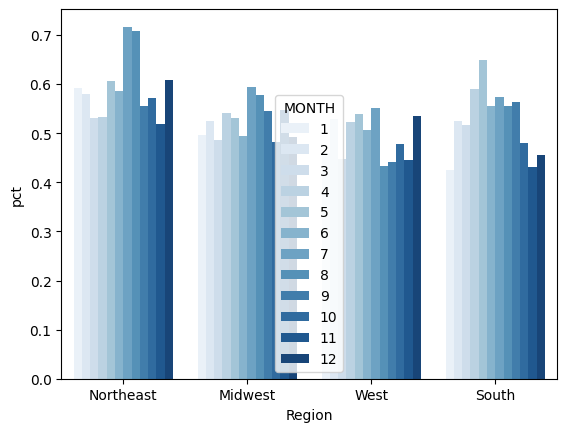

In [41]:
# qué porcentaje de sus weather delays son big delays
df_prov = df[df['SIZE_WEATHER_DELAY']!='NO_DELAY'].groupby(['MONTH','Region']) \
			.SIZE_WEATHER_DELAY.value_counts(normalize=True) \
			.rename('pct').reset_index() \
			.sort_values(by=['MONTH', 'SIZE_WEATHER_DELAY', 'pct'], ascending=[True,True,False]) \
			.query("SIZE_WEATHER_DELAY == 'BIG_WEATHER_DELAY'")#.query("MONTH in [1,2,3,4,5,6]")

sns.barplot(x = 'Region',
			y = 'pct',
			hue = 'MONTH',
			data = df_prov,
			palette = "Blues")

plt.show()


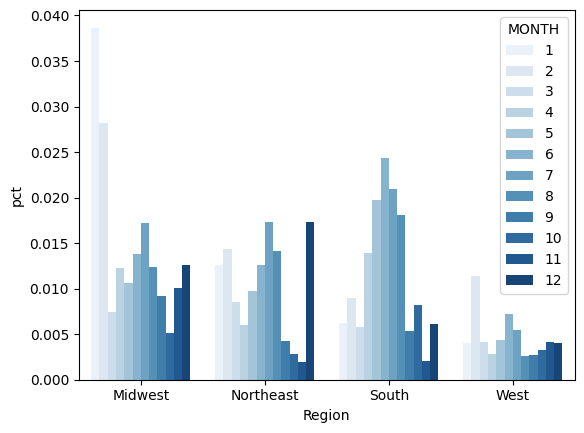

In [42]:
# qué porcentaje de los aviones que parten desde esa región tienen big weather delays
df_prov = df.groupby(['MONTH','Region']) \
			.WEATHER_DELAY.mean() \
			.rename('pct').reset_index() \

sns.barplot(x = 'Region',
			y = 'pct',
			hue = 'MONTH',
			data = df_prov,
			palette = "Blues")

plt.show()

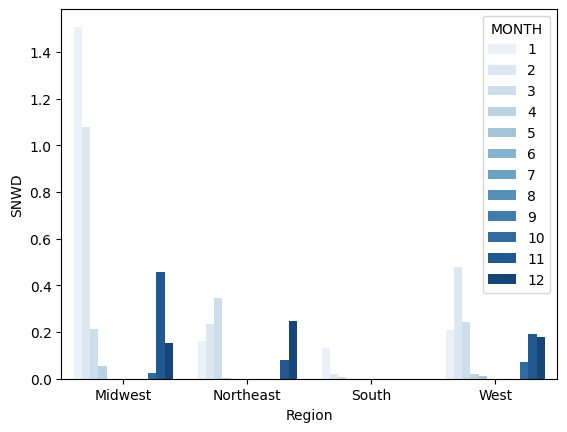

In [43]:
df_prov = df.groupby(['MONTH','Region']) \
			.SNWD.mean().reset_index() \

sns.barplot(x = 'Region',
			y = 'SNWD',
			hue = 'MONTH',
			data = df_prov,
			palette = "Blues")

plt.show()

In [49]:
px.line(df.drop_duplicates(subset=['MONTH','CARRIER_NAME']), x='MONTH', y='AIRLINE_FLIGHTS_MONTH', \
    color='CARRIER_NAME')

In [62]:
top_delayed_airlines = df.groupby(['CARRIER_NAME']).DEP_DEL15.mean().reset_index().sort_values(by='DEP_DEL15').tail(5)

df_prov = df[df['CARRIER_NAME'].isin(top_delayed_airlines.CARRIER_NAME.unique())] \
    .groupby(['MONTH','CARRIER_NAME']).DEP_DEL15.mean().reset_index() \
    .sort_values(by='DEP_DEL15').sort_values(by='MONTH').reset_index(drop=True)

fig = px.line(df_prov, x='MONTH', y='DEP_DEL15', \
    color='CARRIER_NAME')

fig.update_yaxes(range=[0, 0.35])
fig.show()

In [63]:
least_delayed_airlines = df.groupby(['CARRIER_NAME']).DEP_DEL15.mean().reset_index().sort_values(by='DEP_DEL15').head(5)

df_prov = df[df['CARRIER_NAME'].isin(least_delayed_airlines.CARRIER_NAME.unique())] \
    .groupby(['MONTH','CARRIER_NAME']).DEP_DEL15.mean().reset_index() \
    .sort_values(by='DEP_DEL15').sort_values(by='MONTH').reset_index(drop=True)

fig = px.line(df_prov, x='MONTH', y='DEP_DEL15', \
    color='CARRIER_NAME')

fig.update_yaxes(range=[0, 0.35])
fig.show()

In [64]:
prov_least = df[df['CARRIER_NAME'].isin(least_delayed_airlines.CARRIER_NAME.unique())] \
    .groupby(['CARRIER_NAME']).Region.value_counts(normalize=True) \
    .rename('pct').reset_index()

fig = px.bar(
    pd.pivot_table(prov_least, values='pct', index=['CARRIER_NAME'],
                    columns=['Region'], aggfunc=np.mean, fill_value=0).reset_index() \
                    [['CARRIER_NAME', 'West', "Midwest", "Northeast", 'South']], 
    x="CARRIER_NAME", y=['West',"Midwest", "Northeast", 'South'], 
    title="Perce"
)

fig.update_layout(barmode='group')
fig.update_yaxes(range=[0, 1])  

In [112]:
prov_top = df[df['CARRIER_NAME'].isin(top_delayed_airlines.CARRIER_NAME.unique())] \
    .groupby(['CARRIER_NAME']).Region.value_counts(normalize=True) \
    .rename('pct').reset_index()

fig = px.bar(
    pd.pivot_table(prov_top, values='pct', index=['CARRIER_NAME'],
                    columns=['Region'], aggfunc=np.mean, fill_value=0).reset_index() \
                    [['CARRIER_NAME', 'West', "Midwest", "Northeast", 'South']], 
    x="CARRIER_NAME", y=['West',"Midwest", "Northeast", 'South'], 
    title="Perce"
)

fig.update_layout(barmode='group')
fig.update_yaxes(range=[0, 1])  

In [113]:
fig = px.line(

    df[df['CARRIER_NAME'].isin(least_delayed_airlines.CARRIER_NAME.unique())] \
    .groupby(['CARRIER_NAME', 'MONTH']).AIRLINE_FLIGHTS_MONTH.mean().rename('count').reset_index(),

    color="CARRIER_NAME", y='count', x='MONTH',
    title="Perce"
)

fig.update_layout(barmode='group')
fig.update_yaxes(range=[0, 120000])  

In [114]:
fig = px.line(

    df[df['CARRIER_NAME'].isin(top_delayed_airlines.CARRIER_NAME.unique())] \
    .groupby(['CARRIER_NAME', 'MONTH']).AIRLINE_FLIGHTS_MONTH.mean().rename('count').reset_index(),

    color="CARRIER_NAME", y='count', x='MONTH',
    title="Perce"
)

fig.update_layout(barmode='group')
fig.update_yaxes(range=[0, 120000])  

In [ ]:
# por aerolinea tipos de delays
# aerolineas con más big delays

In [ ]:
# las aerolineas más delayed tienen la misma distr de tipos de delay?
# airlines mas delayed son mas big delayed?

In [115]:
df[df['CARRIER_NAME'].isin(least_delayed_airlines.CARRIER_NAME.unique())] \
    .groupby(['CARRIER_NAME']).Region.value_counts(normalize=True) \
    .rename('pct').reset_index()

,CARRIER_NAME,Region,pct
0,Alaska Airlines Inc.,West,0.841082
1,Alaska Airlines Inc.,South,0.070624
2,Alaska Airlines Inc.,Northeast,0.056443
3,Alaska Airlines Inc.,Midwest,0.031850
4,Delta Air Lines Inc.,South,0.469703
5,Delta Air Lines Inc.,West,0.219875
6,Delta Air Lines Inc.,Midwest,0.196058
7,Delta Air Lines Inc.,Northeast,0.114364
8,Endeavor Air Inc.,South,0.442606
9,Endeavor Air Inc.,Northeast,0.317480


In [65]:
prov_least = df[df['CARRIER_NAME'].isin(least_delayed_airlines.CARRIER_NAME.unique())] \
    .groupby(['CARRIER_NAME']).Region.value_counts(normalize=True) \
    .rename('pct').reset_index()

fig = px.bar(
    pd.pivot_table(prov_least, values='pct', index=['CARRIER_NAME'],
                    columns=['Region'], aggfunc=np.mean, fill_value=0).reset_index() \
                    [['CARRIER_NAME', 'West', "Midwest", "Northeast", 'South']], 
    x="CARRIER_NAME", y=['West',"Midwest", "Northeast", 'South'], 
    title="Perce"
)

fig.update_layout(barmode='group')
fig.update_yaxes(range=[0, 1])  

In [ ]:
prov_top = df[df['CARRIER_NAME'].isin(top_delayed_airlines.CARRIER_NAME.unique())] \
    .groupby(['CARRIER_NAME']).Region.value_counts(normalize=True) \
    .rename('pct').reset_index()

fig = px.bar(
    pd.pivot_table(prov_top, values='pct', index=['CARRIER_NAME'],
                    columns=['Region'], aggfunc=np.mean, fill_value=0).reset_index() \
                    [['CARRIER_NAME', 'West', "Midwest", "Northeast", 'South']], 
    x="CARRIER_NAME", y=['West',"Midwest", "Northeast", 'South'], 
    title="Perce"
)

fig.update_layout(barmode='group')
fig.update_yaxes(range=[0, 1])  

In [144]:
carrier_df = df[df['DEP_DEL15']==1].groupby(['CARRIER_NAME']) \
        .CARRIER_DELAY.value_counts(normalize=True).rename('CARRIER_DELAY_PERC') \
        .reset_index() \
        .query("CARRIER_DELAY == 1").drop(columns='CARRIER_DELAY')

carrier_df = pd.melt(carrier_df, 
    id_vars='CARRIER_NAME', 
    value_vars=list(carrier_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')


lateaircraft_df = df[df['DEP_DEL15']==1].groupby(['CARRIER_NAME']) \
        .LATE_AIRCRAFT_DELAY.value_counts(normalize=True).rename('LATEAIRCRAFT_DELAY_PERC') \
        .reset_index() \
        .query("LATE_AIRCRAFT_DELAY == 1").drop(columns='LATE_AIRCRAFT_DELAY')

lateaircraft_df = pd.melt(lateaircraft_df, 
    id_vars='CARRIER_NAME', 
    value_vars=list(lateaircraft_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')


nas_df = df[df['DEP_DEL15']==1].groupby(['CARRIER_NAME']) \
        .NAS_DELAY.value_counts(normalize=True).rename('NAS_DELAY_PERC') \
        .reset_index() \
        .query("NAS_DELAY == 1").drop(columns='NAS_DELAY')

nas_df = pd.melt(nas_df, 
    id_vars='CARRIER_NAME', 
    value_vars=list(nas_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')


weather_df = df[df['DEP_DEL15']==1].groupby(['CARRIER_NAME']) \
        .WEATHER_DELAY.value_counts(normalize=True).rename('WEATHER_DELAY_PERC') \
        .reset_index() \
        .query("WEATHER_DELAY == 1").drop(columns='WEATHER_DELAY')

weather_df = pd.melt(weather_df, 
    id_vars='CARRIER_NAME', 
    value_vars=list(weather_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')


other_df = df[df['DEP_DEL15']==1].groupby(['CARRIER_NAME']) \
        .OTHER_CAUSES.value_counts(normalize=True).rename('OTHER_DELAY_PERC') \
        .reset_index() \
        .query("OTHER_CAUSES == 1").drop(columns='OTHER_CAUSES')

other_df = pd.melt(other_df, 
    id_vars='CARRIER_NAME', 
    value_vars=list(other_df.columns[1:]), 
    var_name='Delay Cause', 
    value_name='Percentage')

In [148]:
df_prov = pd.concat([lateaircraft_df, carrier_df, nas_df, weather_df, other_df])

fig = px.bar(df_prov, x="CARRIER_NAME", 
            color=df_prov["Delay Cause"].map({"CARRIER_DELAY_PERC":"Carrier Delay","LATEAIRCRAFT_DELAY_PERC":"Late Aircraft Delay", \
                "NAS_DELAY_PERC":"NAS Delay", "WEATHER_DELAY_PERC":"Weather Delay", 'OTHER_DELAY_PERC':'Other'}),
            y='Percentage',
            title="Cause of Delay Distribution for Each Airline",
            barmode='group',
            height=700, width=1100,
            category_orders={'CARRIER_NAME': 
                            df.groupby(['CARRIER_NAME']).DEP_DEL15.mean().reset_index().sort_values(by='DEP_DEL15', ascending=False)["CARRIER_NAME"]}
            )

fig.show()

In [166]:
df.groupby(['CARRIER_NAME']).DEP_DEL15.mean().sort_values().reset_index().reset_index()

,index,CARRIER_NAME,DEP_DEL15
0,0,Hawaiian Airlines Inc.,0.087065
1,1,Delta Air Lines Inc.,0.146386
2,2,"Midwest Airline, Inc.",0.163793
3,3,Alaska Airlines Inc.,0.164692
4,4,Endeavor Air Inc.,0.174859
5,5,SkyWest Airlines Inc.,0.178232
6,6,American Eagle Airlines Inc.,0.179871
7,7,Spirit Air Lines,0.187864
8,8,Allegiant Air,0.189324
9,9,Mesa Airlines Inc.,0.194398


In [168]:
t

,CARRIER_NAME,DISTANCE_count,DISTANCE_sum,DEP_DELAY_NEW,index,DEP_DEL15
0,Alaska Airlines Inc.,239337,333590874.0,2409721.0,3000,0.164692
1,Allegiant Air,42636,36000539.0,623420.0,8000,0.189324
2,American Airlines Inc.,903640,900188711.0,13392218.0,12000,0.200688
3,American Eagle Airlines Inc.,228792,107629615.0,2811388.0,6000,0.179871
4,Atlantic Southeast Airlines,99044,47940228.0,2200850.0,14000,0.232260
5,Comair Inc.,219324,88277512.0,3168309.0,10000,0.194630
6,Delta Air Lines Inc.,938346,860168941.0,10305753.0,1000,0.146386
7,Endeavor Air Inc.,203827,97512835.0,2980914.0,4000,0.174859
8,Frontier Airlines Inc.,120872,126302075.0,2284178.0,16000,0.260904
9,Hawaiian Airlines Inc.,74898,60326029.0,385533.0,0,0.087065


In [178]:
t = df.groupby('CARRIER_NAME').agg({'DISTANCE': ['count', 'sum'], 'DEP_DELAY_NEW':'sum'}).reset_index()
t.columns = t.columns.get_level_values(0)
t.columns = ['CARRIER_NAME', 'DISTANCE_count', 'DISTANCE_sum', 'DEP_DELAY_NEW']

t = t.merge(df.groupby(['CARRIER_NAME']).DEP_DEL15.mean().sort_values().reset_index().reset_index(), 
            on=['CARRIER_NAME'])

t['Rank'] = (t['index'] + 1) 

# Plot 

fig = px.scatter(t,
    x = 'DISTANCE_count', y = 'DEP_DELAY_NEW', title='Number of Flights and Total Time in Delays for each Airline',
    color='Rank', color_continuous_scale=px.colors.diverging.RdYlGn[::-1],
    size='Rank', height=700, hover_name='CARRIER_NAME')

fig.update_layout(plot_bgcolor='white',
                  xaxis_title='Number of flights in 2019', yaxis_title='Total minutes in delays')

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.update_xaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.show()

fig.update_layout({
#'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig12.png", scale=2)

In [215]:
t['short_name'] = pd.Series(['Alaska','Allegiant','American','American Eagle', 'Atlantic Southeast',
                             'Comair', 'Delta', 'Endeavor', 'Frontier', 'Hawaiian', 'JetBlue', 'Mesa', 'Midwest',
                             'SkyWest', 'Southwest', 'Spirit', 'United'])

fig = px.scatter(t,
    x = 'DISTANCE_sum', y = 'DEP_DELAY_NEW', title='Distance Traveled and Total Time in Delays for each Airline',
    color='Rank', color_continuous_scale=px.colors.diverging.RdYlGn[::-1],
    size='DISTANCE_count', height=900, hover_name='CARRIER_NAME', text='short_name', width=1200)

fig.update_layout(plot_bgcolor='white',
                  xaxis_title='Total distance traveled in 2019', yaxis_title='Total minutes in delays',
                  legend= {'itemsizing': 'constant'})

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.update_xaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

def improve_text_position(x):
    """ it is more efficient if the x values are sorted """

    positions = ['top center', 'bottom center', 'top left', 'top right', 'bottom right', 'bottom left'] 
    return [positions[i % len(positions)] for i in range(len(x))]

fig.update_traces(textposition=improve_text_position(t['DISTANCE_sum']), textfont_size=11)

fig.show()

fig.update_layout({
#'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig13.png", scale=2)

In [120]:
t['delay_mins_per_mile'] = t['DEP_DELAY_NEW'] / t['DISTANCE_sum']
t = t.merge(df.groupby(['CARRIER_NAME']).DEP_DEL15.mean().sort_values().reset_index())

fig = px.scatter(t,
    x = 'DISTANCE_sum', y = 'delay_mins_per_mile', title='Distance Traveled and Total Time in Delays for each Airline',
    size='DISTANCE_count', color='DEP_DEL15', hover_name='CARRIER_NAME')

fig.update_layout(plot_bgcolor='white',
                  xaxis_title='Total distance traveled in 2019', yaxis_title='Delay minutes per mile')

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.update_xaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.show()

fig.update_layout({
#'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig13.png", scale=2)

In [121]:
t['delay_mins_per_flight'] = t['DEP_DELAY_NEW'] / t['DISTANCE_count']


fig = px.scatter(t,
    x = 'DISTANCE_sum', y = 'delay_mins_per_flight', title='Distance Traveled and Total Time in Delays for each Airline',
    color='DEP_DEL15')

fig.update_layout(plot_bgcolor='white',
                  xaxis_title='Total distance traveled in 2019', yaxis_title='Delay minutes per flight')

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.update_xaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.show()

fig.update_layout({
#'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig13.png", scale=2)

In [153]:
df.groupby(['CARRIER_NAME', 'Region']).DEP_DEL15.mean().sort_values().reset_index()

,CARRIER_NAME,Region,DEP_DEL15
0,Endeavor Air Inc.,West,0.000000
1,Hawaiian Airlines Inc.,West,0.086810
2,Hawaiian Airlines Inc.,Northeast,0.120000
3,Delta Air Lines Inc.,Midwest,0.136605
4,Allegiant Air,West,0.139881
...,...,...,...
60,Atlantic Southeast Airlines,Midwest,0.276646
61,JetBlue Airways,South,0.281841
62,Frontier Airlines Inc.,West,0.282511
63,Frontier Airlines Inc.,Northeast,0.286547


In [155]:
t = df.groupby(['CARRIER_NAME', 'Region']).agg({'DISTANCE': ['count', 'sum'], 'DEP_DELAY_NEW':'sum'}).reset_index()
t.columns = t.columns.get_level_values(0)
t.columns = ['CARRIER_NAME', 'Region','DISTANCE_count', 'DISTANCE_sum', 'DEP_DELAY_NEW']

t['delay_mins_per_mile'] = t['DEP_DELAY_NEW'] / t['DISTANCE_sum']
t = t.merge(df.groupby(['CARRIER_NAME', 'Region']).DEP_DEL15.mean().sort_values().reset_index(), 
            on=['CARRIER_NAME', 'Region'])

# Plot 

fig = px.scatter(t,
    x = 'DISTANCE_sum', y = 'DEP_DELAY_NEW', title='Distance Traveled and Total Time in Delays for each Airline',
    size='DEP_DEL15', hover_name='CARRIER_NAME', facet_row='Region', height=1500
    )

fig.update_layout(plot_bgcolor='white',
                  xaxis_title='Total distance traveled in 2019', yaxis_title='Total minutes in delays')

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.update_xaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.show()

fig.update_layout({
#'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig13.png", scale=2)

In [149]:
t = df.groupby(['CARRIER_NAME', 'Region']).agg({'DISTANCE': ['count', 'sum'], 'DEP_DELAY_NEW':'sum'}).reset_index()
t.columns = t.columns.get_level_values(0)
t.columns = ['CARRIER_NAME', 'Region','DISTANCE_count', 'DISTANCE_sum', 'DEP_DELAY_NEW']

t['delay_mins_per_mile'] = t['DEP_DELAY_NEW'] / t['DISTANCE_sum']
t = t.merge(df.groupby(['CARRIER_NAME', 'Region']).DEP_DEL15.mean().sort_values().reset_index(), 
            on=['CARRIER_NAME', 'Region'])

# Plot 

t['delay_mins_per_flight'] = t['DEP_DELAY_NEW'] / t['DISTANCE_count']


fig = px.scatter(t,
    x = 'DEP_DEL15', y = 'delay_mins_per_flight', title='Distance Traveled and Total Time in Delays for each Airline',
    size='DISTANCE_count', color='DEP_DEL15', hover_name='CARRIER_NAME', height=800)

fig.update_layout(plot_bgcolor='white',
                  xaxis_title='Percentage of delayed flights', yaxis_title='Delay minutes per flight')

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.update_xaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.show()

In [133]:
df.groupby(['CARRIER_NAME']).DEP_DEL15.mean().reset_index().sort_values(by='DEP_DEL15')

,CARRIER_NAME,DEP_DEL15
9,Hawaiian Airlines Inc.,0.087065
6,Delta Air Lines Inc.,0.146386
12,"Midwest Airline, Inc.",0.163793
0,Alaska Airlines Inc.,0.164692
7,Endeavor Air Inc.,0.174859
13,SkyWest Airlines Inc.,0.178232
3,American Eagle Airlines Inc.,0.179871
15,Spirit Air Lines,0.187864
1,Allegiant Air,0.189324
11,Mesa Airlines Inc.,0.194398


In [145]:
t = df.groupby(['CARRIER_NAME', 'Region']).agg({'DISTANCE': ['count', 'sum'], 'DEP_DELAY_NEW':'sum'}).reset_index()
t.columns = t.columns.get_level_values(0)
t.columns = ['CARRIER_NAME', 'Region','DISTANCE_count', 'DISTANCE_sum', 'DEP_DELAY_NEW']

t['delay_mins_per_mile'] = t['DEP_DELAY_NEW'] / t['DISTANCE_sum']
t = t.merge(df.groupby(['CARRIER_NAME', 'Region']).DEP_DEL15.mean().sort_values().reset_index(), 
            on=['CARRIER_NAME', 'Region'])

# Plot 

fig = px.scatter(t,
    x = 'DISTANCE_count', y = 'DEP_DELAY_NEW', title='Distance Traveled and Total Time in Delays for each Airline',
    size='DISTANCE_sum', color='DEP_DEL15', hover_name='CARRIER_NAME', facet_row='Region', height=1500
    )

fig.update_layout(plot_bgcolor='white',
                  xaxis_title='Total number of flights in 2019', yaxis_title='Total minutes in delays')

fig.update_yaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.update_xaxes(
    ticks='outside',
    gridcolor='lightgrey'
)

fig.show()

fig.update_layout({
#'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_image("images/fig13.png", scale=2)

In [210]:
df.groupby('CARRIER_NAME').DISTANCE.mean().sort_values()

CARRIER_NAME
Comair Inc.                      402.498185
American Eagle Airlines Inc.     470.425605
Endeavor Air Inc.                478.409803
Atlantic Southeast Airlines      484.029603
SkyWest Airlines Inc.            530.881771
Mesa Airlines Inc.               583.958187
Midwest Airline, Inc.            603.200827
Southwest Airlines Co.           745.211448
Hawaiian Airlines Inc.           805.442455
Allegiant Air                    844.369523
Delta Air Lines Inc.             916.686319
American Airlines Inc.           996.180681
Spirit Air Lines                 996.872632
Frontier Airlines Inc.          1044.924176
JetBlue Airways                 1125.828414
United Air Lines Inc.           1202.883439
Alaska Airlines Inc.            1393.812382
Name: DISTANCE, dtype: float64

In [278]:
df[df['DEP_DEL15']==1].groupby('CARRIER_NAME').DEP_DELAY_NEW.mean().sort_values()

CARRIER_NAME
Hawaiian Airlines Inc.          45.484435
Southwest Airlines Co.          49.477792
Alaska Airlines Inc.            55.229698
American Eagle Airlines Inc.    64.178213
Delta Air Lines Inc.            68.448846
American Airlines Inc.          68.656669
Frontier Airlines Inc.          68.898814
Comair Inc.                     69.781807
Spirit Air Lines                71.779767
Allegiant Air                   72.153865
Midwest Airline, Inc.           73.936416
United Air Lines Inc.           79.931334
Endeavor Air Inc.               80.447462
JetBlue Airways                 81.197956
SkyWest Airlines Inc.           83.651396
Mesa Airlines Inc.              86.529993
Atlantic Southeast Airlines     93.175404
Name: DEP_DELAY_NEW, dtype: float64

In [279]:
df.groupby('CARRIER_NAME').DISTANCE.count().sort_values()

CARRIER_NAME
Allegiant Air                     42636
Hawaiian Airlines Inc.            74898
Atlantic Southeast Airlines       99044
Frontier Airlines Inc.           120872
Mesa Airlines Inc.               177600
Spirit Air Lines                 189419
Endeavor Air Inc.                203827
Comair Inc.                      219324
American Eagle Airlines Inc.     228792
Alaska Airlines Inc.             239337
JetBlue Airways                  269596
Midwest Airline, Inc.            300154
SkyWest Airlines Inc.            584204
United Air Lines Inc.            601044
American Airlines Inc.           903640
Delta Air Lines Inc.             938346
Southwest Airlines Co.          1296329
Name: DISTANCE, dtype: int64